In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mdtraj as md

import torch
from torch import nn

from snrv import Snrv

In [2]:
traj = md.load("../traj_2000_2500.dcd", top="../em.gro")
biasing_atom_ids = np.array([atom.index for atom in traj.topology.atoms if
                              (atom.residue.name != 'HOH' and atom.element.symbol != "H")])
pos = torch.from_numpy(traj.xyz)
box = torch.from_numpy(np.asarray([np.diag(i) for i in traj.unitcell_vectors])).view(-1, 1, 3)

In [3]:
def generate_dihedral_indices_linear(index_list):
    i_list = []
    j_list = []
    k_list = []
    l_list = []

    for n in range(len(index_list) - 3):
        i_list.append(index_list[n])
        j_list.append(index_list[n + 1])
        k_list.append(index_list[n + 2])
        l_list.append(index_list[n + 3])

    return (
        torch.tensor(i_list, dtype=torch.long),
        torch.tensor(j_list, dtype=torch.long),
        torch.tensor(k_list, dtype=torch.long),
        torch.tensor(l_list, dtype=torch.long),
    )

i_list, j_list, k_list, l_list = generate_dihedral_indices_linear(biasing_atom_ids)

In [4]:
def compute_mic_dihedrals(pos, box, i, j, k, l):
    # pos: [T, N, 3]
    # box: [T, 1, 3] (broadcastable)
    # i, j, k, l: [M]

    # MIC vectors
    b1 = pos[:, j, :] - pos[:, i, :]
    b1 = b1 - box * torch.round(b1 / box)

    b2 = pos[:, k, :] - pos[:, j, :]
    b2 = b2 - box * torch.round(b2 / box)

    b3 = pos[:, l, :] - pos[:, k, :]
    b3 = b3 - box * torch.round(b3 / box)

    # Normalize b2 for later
    b2_norm = torch.nn.functional.normalize(b2, dim=-1)

    # Compute normals to the planes
    n1 = torch.cross(b1, b2, dim=-1)  # plane i-j-k
    n2 = torch.cross(b2, b3, dim=-1)  # plane j-k-l

    # Normalize
    n1 = torch.nn.functional.normalize(n1, dim=-1)
    n2 = torch.nn.functional.normalize(n2, dim=-1)

    # Compute cosine and sine terms
    cos_phi = (n1 * n2).sum(dim=-1).clamp(-1.0, 1.0)
    sin_phi = (torch.cross(n1, n2, dim=-1) * b2_norm).sum(dim=-1)

    # Final torsion angle
    dihedrals = torch.atan2(sin_phi, cos_phi)  # shape: [T, M], radians

    return dihedrals

In [6]:
traj_x_dih = compute_mic_dihedrals(pos, box, i_list, j_list, k_list, l_list)
traj_x = torch.concat([torch.sin(traj_x_dih), torch.cos(traj_x_dih)], axis=1)
traj_x = traj_x.to(torch.double)

In [8]:
class PCAModule(nn.Module):
    def __init__(self, n_components: int):
        """
        A differentiable and torchscript-compatible PCA module.
        
        Args:
            n_components (int): Number of principal components to retain.
        """
        super().__init__()
        self.n_components = n_components
        self.register_buffer("mean", torch.tensor([]))  # shape (D,)
        self.register_buffer("components", torch.tensor([]))  # shape (D, k)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fit PCA on input data and return the projection.

        Args:
            x (torch.Tensor): Input tensor of shape (N, D)

        Returns:
            torch.Tensor: PCA-transformed tensor of shape (N, n_components)
        """
        # Center the input
        mean = x.mean(dim=0, keepdim=True)
        x_centered = x - mean

        # Compute covariance matrix
        cov = torch.matmul(x_centered.T, x_centered) / (x_centered.size(0) - 1)

        # Eigendecomposition
        eigvals, eigvecs = torch.linalg.eigh(cov)

        # Sort eigenvectors by eigenvalue magnitude
        sorted_indices = torch.argsort(eigvals, descending=True)
        topk_eigvecs = eigvecs[:, sorted_indices[:self.n_components]]  # (D, k)

        # Save for future transform
        self.mean = mean.squeeze(0)
        self.components = topk_eigvecs

        # Project
        return torch.matmul(x_centered, topk_eigvecs)

    def transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Project new data using the previously learned principal components.

        Args:
            x (torch.Tensor): New input tensor of shape (N, D)

        Returns:
            torch.Tensor: Projected tensor of shape (N, n_components)
        """
        x_centered = x - self.mean
        return torch.matmul(x_centered, self.components)


In [9]:
model = PCAModule(2)
projected_train_x = model(traj_x)

Text(0, 0.5, 'PC1')

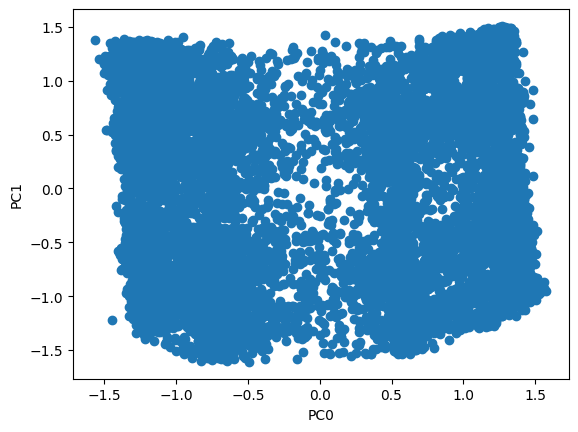

In [10]:
plt.scatter(projected_train_x[:, 0], projected_train_x[:, 1])
plt.xlabel("PC0")
plt.ylabel("PC1")

In [13]:
class CV(torch.nn.Module):
    def __init__(self, model, idx):
        super().__init__()
        self.model = model
        self.idx = idx
        self.register_buffer("i_list", i_list)
        self.register_buffer("j_list", j_list)
        self.register_buffer("k_list", k_list)
        self.register_buffer("l_list", l_list)

    def compute_mic_dihedrals(self, pos, box):
        # pos: [T, N, 3]
        # box: [T, 1, 3] (broadcastable)
        # i, j, k, l: [M]

        # MIC vectors
        b1 = pos[self.j_list, :] - pos[self.i_list, :]
        b1 = b1 - box * torch.round(b1 / box)

        b2 = pos[self.k_list, :] - pos[self.j_list, :]
        b2 = b2 - box * torch.round(b2 / box)

        b3 = pos[self.l_list, :] - pos[self.k_list, :]
        b3 = b3 - box * torch.round(b3 / box)

        # Normalize b2 for later
        b2_norm = torch.nn.functional.normalize(b2, dim=-1)

        # Compute normals to the planes
        n1 = torch.cross(b1, b2, dim=-1)  # plane i-j-k
        n2 = torch.cross(b2, b3, dim=-1)  # plane j-k-l

        # Normalize
        n1 = torch.nn.functional.normalize(n1, dim=-1)
        n2 = torch.nn.functional.normalize(n2, dim=-1)

        # Compute cosine and sine terms
        cos_phi = (n1 * n2).sum(dim=-1).clamp(-1.0, 1.0)
        sin_phi = (torch.cross(n1, n2, dim=-1) * b2_norm).sum(dim=-1)

        # Final torsion angle
        dihedrals = torch.atan2(sin_phi, cos_phi)  # shape: [T, M], radians

        return dihedrals

    def forward(self, positions, boxvectors):
        """The forward method returns the energy computed from positions.

        Parameters
        ----------
        positions : torch.Tensor with shape (nparticles, 3)
           positions[i,k] is the position (in nanometers) of spatial dimension k of particle i

        Returns
        -------
        potential : torch.Scalar
           The potential energy (in kJ/mol)
        """
        boxsize = boxvectors.diag()
        feats = self.compute_mic_dihedrals(positions, boxsize)
        feats = torch.concat([torch.sin(feats), torch.cos(feats)], dim=0)
        evecs = self.model.transform(feats.view(1, -1))
        CV = evecs[0][self.idx]
        return CV

model_output_1 = CV(model, 0)
model_output_2 = CV(model, 1)

torch.jit.script(model_output_1).save('cv1.pt')
torch.jit.script(model_output_2).save('cv2.pt')